# CATH prediction accuracy

Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve

In [3]:
rng = np.random.default_rng(42)

In [4]:
plt.rcParams['svg.fonttype'] = 'none'

Results

In [5]:
df = pd.read_table('results.tsv', index_col=0)
df

,class,architecture,topology,superfamily,tmvec1,tmvec2,tmvec2_student,tmalign,foldseek
seq_pair,,,,,,,,,
"107lA00,108lA00",1,1,1,1,0.999900,0.986187,0.974749,0.99929,4.561000e-26
"107lA00,109lA00",1,1,1,1,0.999929,0.991714,0.982852,0.99945,5.002000e-27
"107lA00,110lA00",1,1,1,1,0.999920,0.987399,0.979588,0.99947,7.214000e-26
"107lA00,111lA00",1,1,1,1,0.999960,0.996667,0.987025,0.99929,1.908000e-26
"107lA00,112lA00",1,1,1,1,0.999958,0.988583,0.985575,0.99892,2.422000e-26
...,...,...,...,...,...,...,...,...,...
"1b7jA00,1b7lA00",0,0,0,0,0.480856,0.353141,0.279840,0.26842,NaN
"1b7jA00,1b7mA00",0,0,0,0,0.490731,0.345178,0.276629,0.26723,NaN
"1b7kA00,1b7lA00",0,0,0,0,0.478964,0.334604,0.259384,0.27057,NaN


In [6]:
bins = [0.0, 0.25, 0.5, 0.75, 1.0]
df['bin'] = pd.cut(df['tmalign'], bins=bins, right=True)

In [7]:
methods = ['tmvec1', 'tmvec2', 'tmvec2_student', 'tmalign', 'foldseek']
names = ['TM-Vec', 'TM-Vec 2', 'TM-Vec 2s', 'TM-align', 'Foldseek']
name_map = {method: name for method, name in zip(methods, names)}

In [8]:
tmvecs = ['tmvec1', 'tmvec2', 'tmvec2_student']

In [9]:
levels = ['class', 'architecture', 'topology', 'superfamily']

In [10]:
cmap = plt.get_cmap('tab10')
palette = {method: cmap(i) for i, method in enumerate(methods)}

Correlation

In [11]:
df_score = df[tmvecs + ['tmalign']].dropna(how='any')
df_score

,tmvec1,tmvec2,tmvec2_student,tmalign
seq_pair,,,,
"107lA00,108lA00",0.999900,0.986187,0.974749,0.99929
"107lA00,109lA00",0.999929,0.991714,0.982852,0.99945
"107lA00,110lA00",0.999920,0.987399,0.979588,0.99947
"107lA00,111lA00",0.999960,0.996667,0.987025,0.99929
"107lA00,112lA00",0.999958,0.988583,0.985575,0.99892
...,...,...,...,...
"1b7jA00,1b7lA00",0.480856,0.353141,0.279840,0.26842
"1b7jA00,1b7mA00",0.490731,0.345178,0.276629,0.26723
"1b7kA00,1b7lA00",0.478964,0.334604,0.259384,0.27057


In [12]:
score_bins = np.arange(0, 1.015, 0.015)

In [13]:
text = 'R = {:.3f}\nMAE = {:.3f}\nRMSE = {:.3f}'

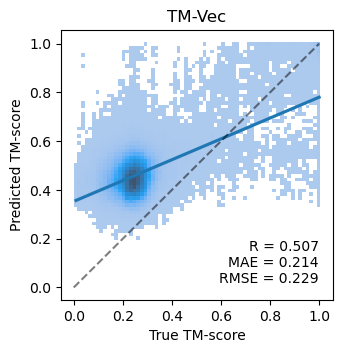

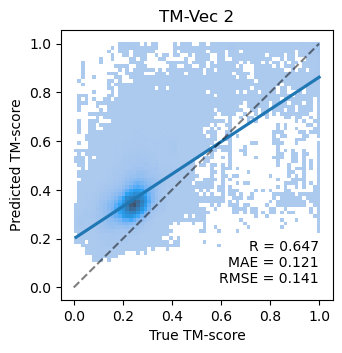

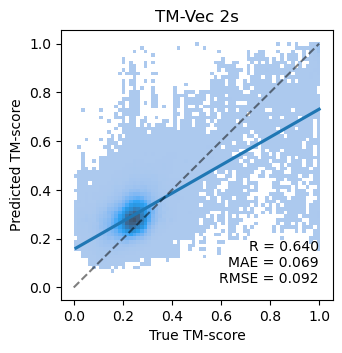

In [14]:
x = df_score['tmalign'].to_numpy()
for method in tmvecs:
    name = name_map[method]

    # Statistics
    y = df_score[method].to_numpy()
    r, p = pearsonr(x, y)
    diff = x - y
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff ** 2))

    # Correlation plot
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.histplot(data=df_score, x='tmalign', y=method, ax=ax, bins=(score_bins, score_bins))
    sns.regplot(data=df_score, x='tmalign', y=method, ax=ax, scatter=False)

    ax.plot((0, 1), (0, 1), 'k--', alpha=0.5)
    ax.text(0.95, 0.05, text.format(r, mae, rmse), transform=ax.transAxes, ha='right', va='bottom')
    ax.set_xlabel('True TM-score')
    ax.set_ylabel(f'Predicted TM-score')
    ax.set_title(name)

    fig.savefig(f'plots/{method}.svg')

Distribution

In [15]:
df_melt = df_score.melt(var_name='Method', value_name='TM-score')

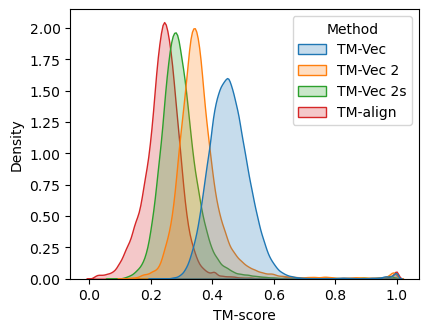

In [16]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.kdeplot(data=df_melt, x='TM-score', hue='Method', fill=True, alpha=0.25, ax=ax)
for text in ax.legend_.texts:
    text.set_text(name_map[text.get_text()])
fig.savefig('plots/distribution.svg')

Errors

In [17]:
df_err = df_score[tmvecs].sub(df['tmalign'], axis=0).abs()

In [18]:
df_err_melt = df_err.melt(var_name='method', value_name='error')

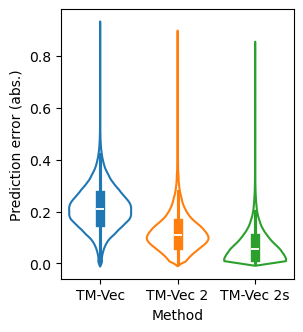

In [19]:
fig, ax = plt.subplots(figsize=(3, 3.5))
sns.violinplot(data=df_err_melt, x='method', y='error', hue='method', order=tmvecs, fill=False, ax=ax)
ax.set_ylabel('Prediction error (abs.)')
ax.set_xlabel('Method')
ax.set_xticks(range(3), [name_map[x] for x in tmvecs])
fig.savefig('plots/tmscore_error.svg')

Errors by bin

In [20]:
df_err['bin'] = df['bin']

In [21]:
df_err_bin_melt = df_err.melt(id_vars='bin', value_vars=tmvecs, var_name='method', value_name='error')
df_err_bin_melt

,bin,method,error
0,"(0.75, 1.0]",tmvec1,0.000610
1,"(0.75, 1.0]",tmvec1,0.000479
2,"(0.75, 1.0]",tmvec1,0.000450
3,"(0.75, 1.0]",tmvec1,0.000670
4,"(0.75, 1.0]",tmvec1,0.001038
...,...,...,...
1498495,"(0.25, 0.5]",tmvec2_student,0.011420
1498496,"(0.25, 0.5]",tmvec2_student,0.009399
1498497,"(0.25, 0.5]",tmvec2_student,0.011186
1498498,"(0.25, 0.5]",tmvec2_student,0.012485


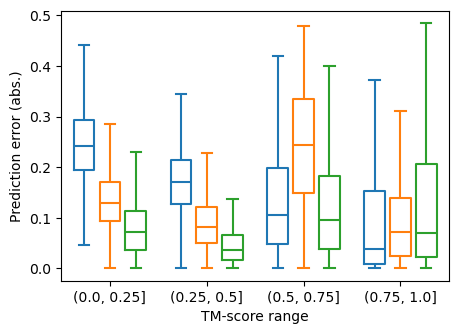

In [22]:
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.boxplot(data=df_err_bin_melt, x='bin', y='error', hue='method', hue_order=tmvecs,
            fill=False, showfliers=False, gap=0.2, legend=False)
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, [name_map[x] for x in tmvecs], title='Method')
ax.set_xlabel('TM-score range')
ax.set_ylabel('Prediction error (abs.)')
fig.savefig('plots/tmscore_error_bin.svg')

Homology (vs. TM-align)

In [23]:
cmap = plt.get_cmap('tab10')
palette = {method: cmap(i) for i, method in enumerate(methods)}

In [24]:
df_score = df.drop(columns='foldseek').dropna(how='any')
print(df_score.shape[0])

499500


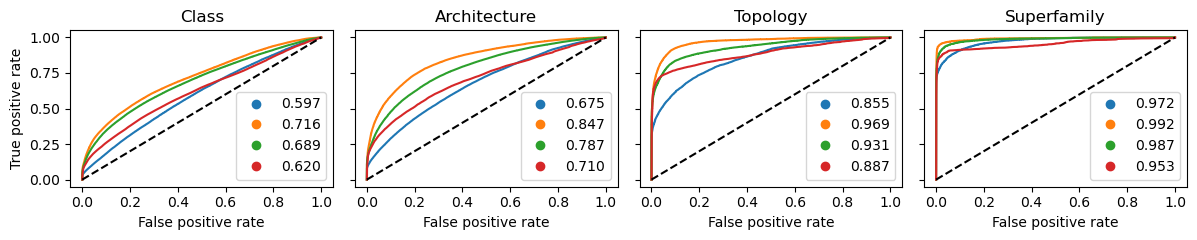

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharey=True)
for i, level in enumerate(levels):
    y_true = df_score[level].to_numpy()
    ax = axes[i]
    for method in tmvecs + ['tmalign']:
        name = name_map[method]
        y_score = df_score[method].to_numpy()
        auroc = roc_auc_score(y_true, y_score)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, label=f'{auroc:.3f}', color=palette[method])
    leg = ax.legend()
    for handle in leg.get_lines():
        handle.set_marker('o')
        handle.set_linestyle('none')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False positive rate')
    if i == 0:
        ax.set_ylabel('True positive rate')
    ax.set_title(level.capitalize())
fig.tight_layout()
fig.savefig('plots/tmscore_roc.svg')

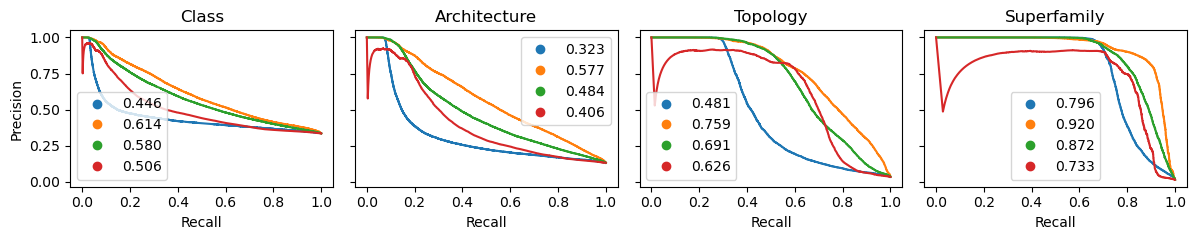

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharey=True)
for i, level in enumerate(levels):
    y_true = df_score[level].to_numpy()
    ax = axes[i]
    for method in tmvecs + ['tmalign']:
        name = name_map[method]
        y_score = df_score[method].to_numpy()
        aupr = average_precision_score(y_true, y_score)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ax.plot(recall, precision, label=f'{aupr:.3f}', color=palette[method])
    leg = ax.legend()
    for handle in leg.get_lines():
        handle.set_marker('o')
        handle.set_linestyle('none')
    ax.set_xlabel('Recall')
    if i == 0:
        ax.set_ylabel('Precision')
    ax.set_title(level.capitalize())
fig.tight_layout()
fig.savefig('plots/tmscore_pr.svg')

Homology (vs. Foldseek)

In [27]:
df_fold = df.drop(columns='tmalign').dropna(how='any')
print(df_fold.shape[0])

78646


In [28]:
values = df_fold['foldseek'].to_numpy()
values[values == 0] = values[values > 0].min() * 0.1
df_fold['foldseek'] = -np.log10(values)

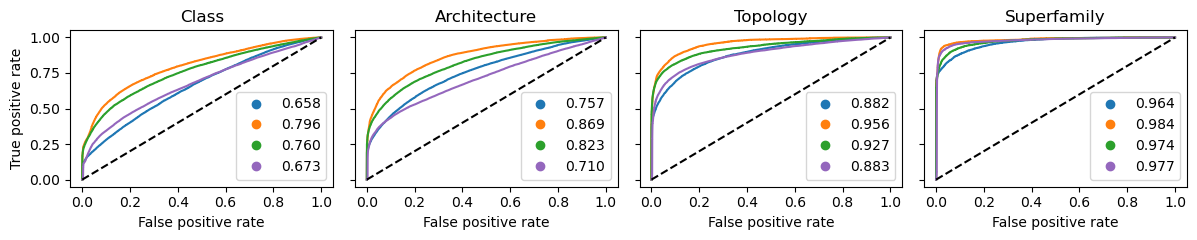

In [29]:
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharey=True)
for i, level in enumerate(levels):
    y_true = df_fold[level].to_numpy()
    ax = axes[i]
    for method in tmvecs + ['foldseek']:
        name = name_map[method]
        y_score = df_fold[method].to_numpy()
        auroc = roc_auc_score(y_true, y_score)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, label=f'{auroc:.3f}', color=palette[method])
    leg = ax.legend()
    for handle in leg.get_lines():
        handle.set_marker('o')
        handle.set_linestyle('none')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False positive rate')
    if i == 0:
        ax.set_ylabel('True positive rate')
    ax.set_title(level.capitalize())
fig.tight_layout()
fig.savefig('plots/foldseek_roc.svg')

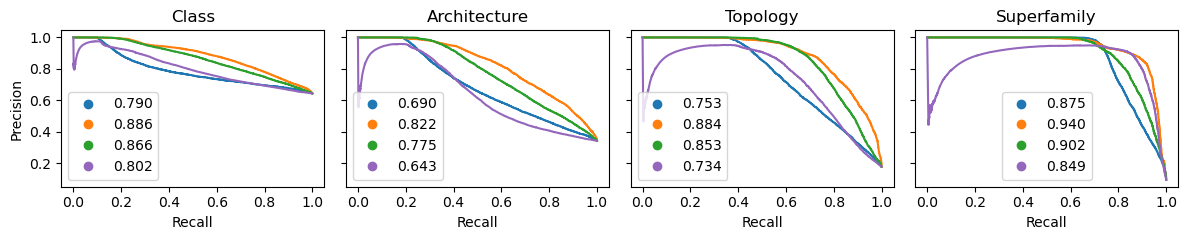

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharey=True)
for i, level in enumerate(levels):
    y_true = df_fold[level].to_numpy()
    ax = axes[i]
    for method in tmvecs + ['foldseek']:
        name = name_map[method]
        y_score = df_fold[method].to_numpy()
        aupr = average_precision_score(y_true, y_score)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ax.plot(recall, precision, label=f'{aupr:.3f}', color=palette[method])
    leg = ax.legend()
    for handle in leg.get_lines():
        handle.set_marker('o')
        handle.set_linestyle('none')
    ax.set_xlabel('Recall')
    if i == 0:
        ax.set_ylabel('Precision')
    ax.set_title(level.capitalize())
fig.tight_layout()
fig.savefig('plots/foldseek_pr.svg')